# Software Pricing
## AB Test and Power Analysis
**Paul Sims**

# Setup

## Imports

In [51]:
# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from pandas_profiling import ProfileReport

# Utility
import rootpath as rp

# ML and stats

from scipy.stats import chi2_contingency, chi2, fisher_exact

import statsmodels.api as sm

from statsmodels.stats import contingency_tables

## Read in data

In [52]:
# Set paths

# Root
rpath = rp.detect() + '/'

# Data directory
data_direct = 'data/'

In [53]:
# Read in data

df_clean = pd.read_csv(rpath+data_direct+'clean/'+'data_clean.csv',
                          sep=",", index_col=0)

In [54]:
# Convert timestamp to date time

df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'],
                                        errors='coerce')

In [55]:
df_clean.head()

,user_id,timestamp,source,device,os,test,price,converted,source_type,date,time,city,country,lat,long
0,604839,2015-05-08 03:38:34,facebook,mobile,apple,0,39.0,0,ads,2015-05-08,03:38:34,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,google,mobile,android,0,39.0,0,seo,2015-05-10,21:08:46,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,bing,mobile,android,0,39.0,0,ads,2015-04-04,15:01:23,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,apple,1,59.0,0,direct_traffic,2015-05-07,07:26:01,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,facebook,web,apple,0,39.0,0,ads,2015-05-24,11:04:40,Fishers,USA,39.95,-86.02


# AB Test 

## Chi Squared Test for independence

- Is there a difference in conversion counts between the two price groups?

**Calculate the exact numbers of conversions in each test group**

In [56]:
# Count instances of converted/non-converted in each test group  

test_cts = (
    df_clean.groupby('test')['converted'] \
               .value_counts(normalize=False).to_frame()
)

In [57]:
# Rename col and flatten df

test_cts = (
    test_cts.rename(columns={"converted": "counts"}).reset_index()
)

In [58]:
test_cts

,test,converted,counts
0,0,0,172939
1,0,1,3489
2,1,0,97658
3,1,1,1530


**Calculate the proportion of conversion for each test**

In [59]:
# Calculate conversion rate in each test group

test_prop = (
    df_clean.groupby('test')['converted'] \
               .value_counts(normalize=True).to_frame()
)

In [60]:
# Reset index and rename converted column

test_prop = (
    test_prop.rename(columns={"converted": "convert_rate"}).reset_index()
)

In [61]:
test_prop

,test,converted,convert_rate
0,0,0,0.980224
1,0,1,0.019776
2,1,0,0.984575
3,1,1,0.015425


In [62]:
# Calculate the difference in conversion rate between the $39 and $59

prop_diff = (
    test_prop.iloc[1]['convert_rate'] - test_prop.iloc[3]['convert_rate']
)

print(f"Conversion rate difference = {prop_diff}")

Conversion rate difference = 0.004350519498304466


- This means the cheaper pricing group $39 has a higher conversion rate
- However, the difference is quite small so might be hard to interpret meaningfully
    - See risk ratio calculations further on as an alternative

In [63]:
from statsmodels.stats.proportion import confint_proportions_2indep

In [64]:
# Create variables for counts of conversions and total observations 

count1 = test_cts.iloc[1]['counts']
nobs1 = test_cts.iloc[0]['counts'] + test_cts.iloc[1]['counts']
count2 = test_cts.iloc[3]['counts']
nobs2 = test_cts.iloc[2]['counts'] + test_cts.iloc[3]['counts']

In [65]:
# Calculate 95% confidence interval for conversion rate difference 

convert_diff_ci = confint_proportions_2indep(count1, nobs1, count2, nobs2, 
                                       method='newcomb', compare='diff')

convert_diff_ci

(0.003337425022623355, 0.005348491809898075)

In [66]:
# Convert conversion data from long to contingency table and to a numpy array 
# note the reindex which orders the columns correctly for calculating the 
# risk ratio later

ct_freq = (
    test_cts.pivot_table(index="test", 
                         columns='converted', 
                         values='counts') \
            .reindex([1,0], axis=1).to_numpy()
)

In [67]:
ct_freq

array([[  3489, 172939],
       [  1530,  97658]])

In [68]:
# Print contingency table 

print('Conversion counts by test condition')
print('Columns are (left to right) converted and non-converted counts')
print('Rows are test condition price $39, price $59')

ct_freq

Conversion counts by test condition
Columns are (left to right) converted and non-converted counts
Rows are test condition price $39, price $59


array([[  3489, 172939],
       [  1530,  97658]])

In [69]:
# Run Chi-Squared test of independence
# Assesses whether the conversion rate is signficantly different from chance

chi, pval, dof, exp = chi2_contingency(ct_freq)
print('P-value = ', round(pval,5))

alpha = 0.05
p = 1 - alpha
critical_value = chi2.ppf(p, dof)

print('chi statistic = %.6f, critical value = %.6f\n' % (chi, critical_value))

P-value =  0.0
chi statistic = 66.972955, critical value = 3.841459



**Interpretation**
- Chi-squared test is significant, indicating that the conversion rate significantly differs between the two test groups
- Need to follow up with an effect size statistic to understand the direction and size of the difference in conversion rate

In [70]:
from statsmodels.stats.contingency_tables import Table2x2

In [71]:
# Create instance of a Table2x2 from stats_models

ct_tab = Table2x2(ct_freq)

In [72]:
# Create summary of comparison methods

ct_tab.summary()

,Estimate,SE,LCB,UCB,p-value
Odds ratio,1.288,,1.212,1.368,0.000
Log odds ratio,0.253,0.031,0.192,0.313,0.000
Risk ratio,1.282,,1.208,1.361,0.000
Log risk ratio,0.248,0.030,0.189,0.308,0.000


In [73]:
# Calculate the Risk Ratio (RR) For conversion

rr_tab = ct_tab.riskratio
rr_tab

1.2820387764691656

In [74]:
# Calculate the Risk Ratio (RR) confidence interval

ct_tab.riskratio_confint(0.05)

(1.2078706685903848, 1.3607611039091665)

**Interpretation**
- The relative risk of conversion in the \(\\$39\) group is 1.28 \(95\% C.I.: 1.21-1.36\) times that of the \(\\$59\) group
- Alternatively, there is a 28% conversion lift in the (\\$39) group compared to the (\\$59) group
- But how do these conversion rates influence total revenue estimates from both price groups, assuming equal sample sizes?

## Compare AB test results on revenue and conversions

In [75]:
# extract conversion rates for each test

df_conver_rate = test_prop.loc[test_prop['converted']==1]

In [76]:
test_cts

,test,converted,counts
0,0,0,172939
1,0,1,3489
2,1,0,97658
3,1,1,1530


In [77]:
# Sample size for test group 1 ($39 pricing)

test_cts.iloc[:2,2].sum()

176428

In [78]:
# Sample size for test group 2 ($59 pricing)

test_cts.iloc[2:4,2].sum()

99188

In [79]:
# Extract conversion counts for each test group

df_counts = test_cts.loc[test_cts['converted']==1].copy()

In [80]:
df_counts

,test,converted,counts
1,0,1,3489
3,1,1,1530


In [81]:
# Add proportions to counts

df_counts['convert_rate'] = df_conver_rate['convert_rate']

In [82]:
# Create new table with revenue added

df_rev = df_counts.copy().reset_index(drop=True)

In [83]:
# Create label for test group

# Create categorical version for plotting
df_rev['test_group'] = np.where(df_rev['test']==0, '$39', '$59')
# Create numeric version for calcs
df_rev['test_group_num'] = np.where(df_rev['test']==0, 39, 59)

In [84]:
# Calculate total revenue for both groups

df_rev['total_revenue'] = df_rev['counts'] * df_rev['test_group_num']

In [85]:
# Calculate mean revenue for both groups

df_rev['total_revenue_avg'] = df_rev['total_revenue']/df_rev['counts']

In [86]:
df_rev

,test,converted,counts,convert_rate,test_group,test_group_num,total_revenue,total_revenue_avg
0,0,1,3489,0.019776,$39,39,136071,39.0
1,1,1,1530,0.015425,$59,59,90270,59.0


- So even though the lower priced variant sells for less, because it sells for more units, it ultimately generates more revenue in the total revenue earned
- For this to profitable, it assumes that costs, such as the cost of producing greater numbers of units, is less than the revenue generated 

In [87]:
df_clean.head()

,user_id,timestamp,source,device,os,test,price,converted,source_type,date,time,city,country,lat,long
0,604839,2015-05-08 03:38:34,facebook,mobile,apple,0,39.0,0,ads,2015-05-08,03:38:34,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,google,mobile,android,0,39.0,0,seo,2015-05-10,21:08:46,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,bing,mobile,android,0,39.0,0,ads,2015-04-04,15:01:23,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,apple,1,59.0,0,direct_traffic,2015-05-07,07:26:01,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,facebook,web,apple,0,39.0,0,ads,2015-05-24,11:04:40,Fishers,USA,39.95,-86.02


 ## Plot the running total for revenue over time grouped by test group


In [88]:
# Filter only conversions
# Remove conversion data without dates

df_convert = df_clean.query("converted == 1 & date.notnull()",
                            engine='python').copy()

In [89]:
# Extract week variable

df_convert['week'] = df_convert['timestamp'].dt.isocalendar().week

In [90]:
# Calculate weekly totals

df_sum_weekly = df_convert.groupby(['test','week'],
                                dropna=False) \
                            ['price'].sum().reset_index()

In [91]:
# Calculate the daily totals

df_sum_daily = df_convert.groupby(['test','date'],
                                dropna=False) \
                            ['price'].sum().reset_index()
#df_sum_daily[:10]

In [92]:
# Order df by date

df_sum_daily = df_sum_daily.sort_values(by=['date'], ascending=True)

In [93]:
# Order df by week

df_sum_weekly = df_sum_weekly.sort_values(by=['week'], ascending=True)

In [94]:
# Calculate the daily running total of revenue grouped by pricing test 

df_sum_daily['rev_cumsum'] = df_sum_daily.groupby('test')['price'].transform(pd.Series.cumsum)

In [95]:
# Calculate the weekly running total of revenue grouped by pricing test 

df_sum_weekly['rev_cumsum'] = df_sum_weekly.groupby('test')['price'].transform(pd.Series.cumsum)

In [96]:
# Scale revenue totals by 1000 for interpretation

df_sum_daily['rev_cumsum_scale'] = df_sum_daily['rev_cumsum']/1000

In [97]:
# Scale revenue totals by 1000 for interpretation

df_sum_weekly['rev_cumsum_scale'] = df_sum_weekly['rev_cumsum']/1000

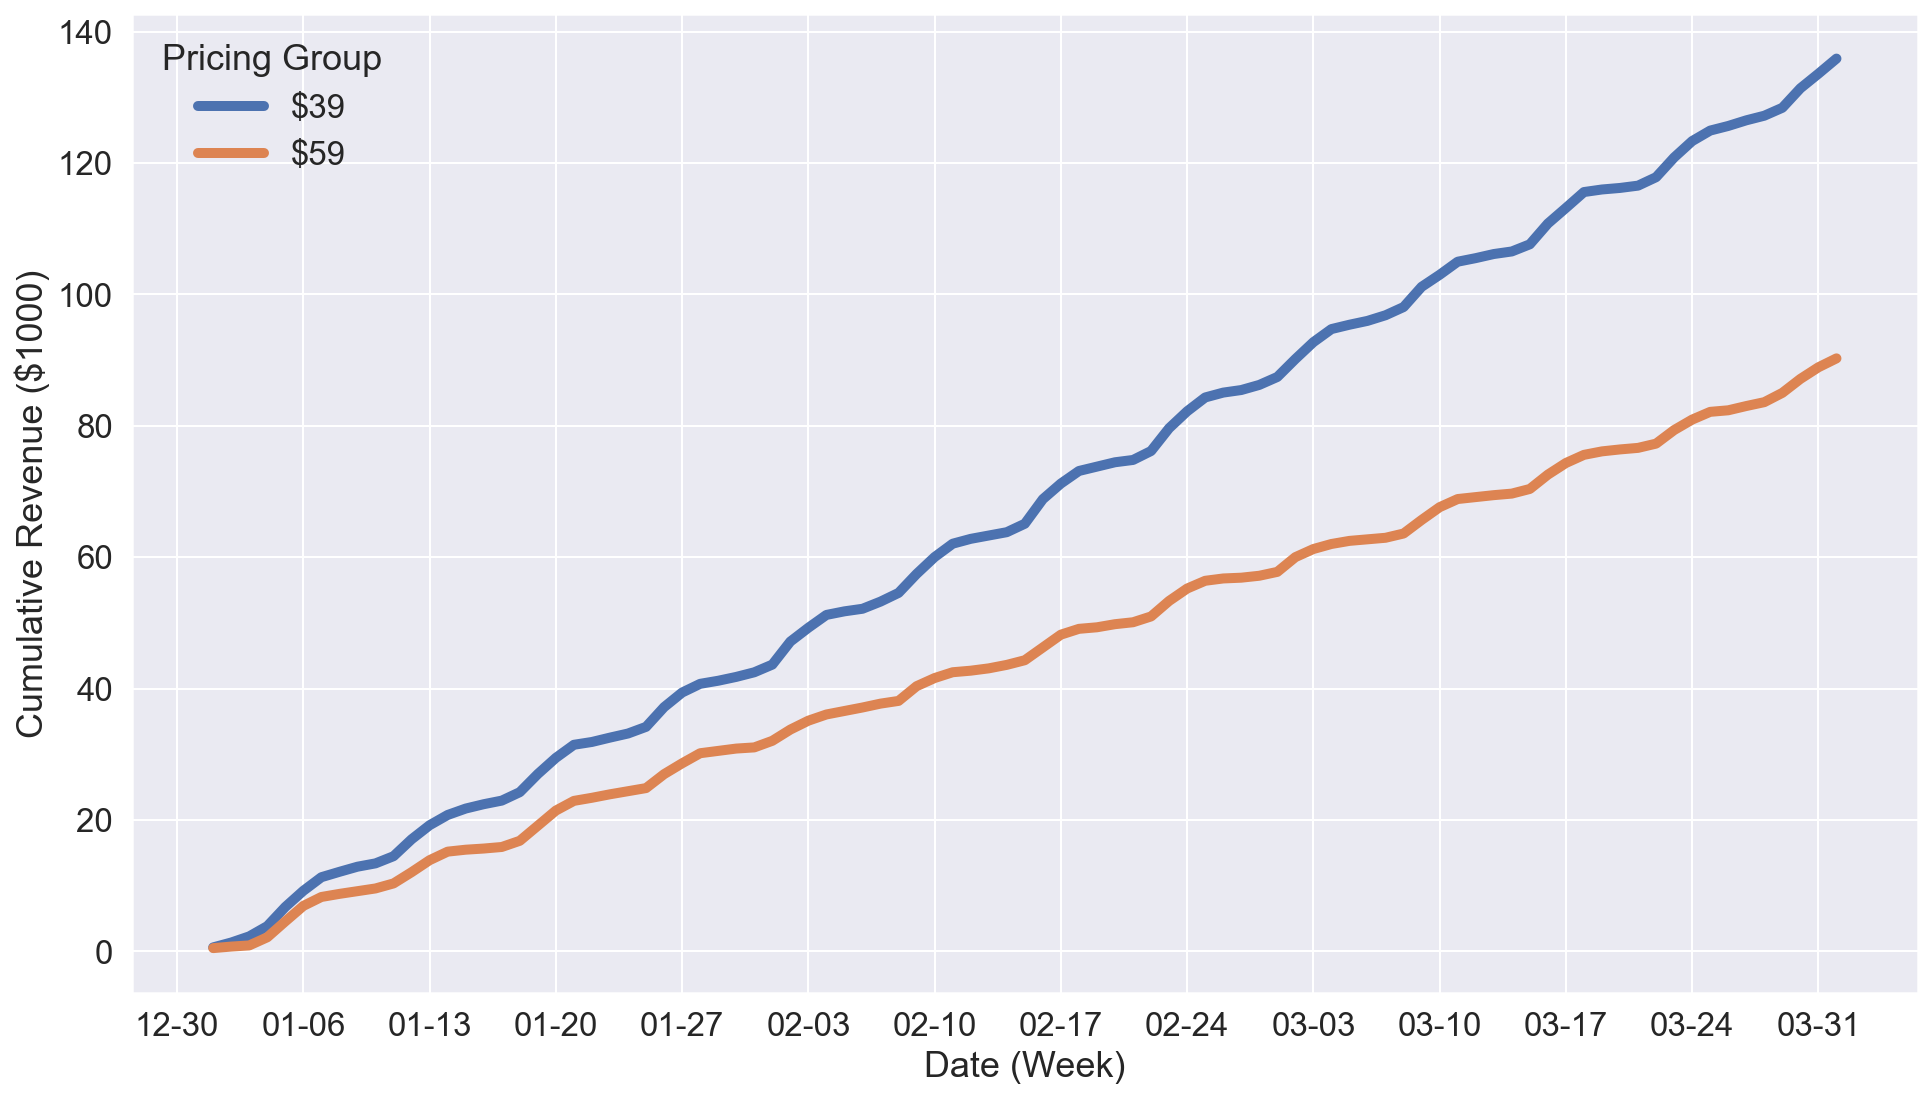

In [98]:
# Plot relationship of total revenue over time for each group

# p = sns.lineplot(data=df_sum_weekly, x="week", y="rev_cumsum_scale",
#                  hue='test', linewidth=5)
p = sns.lineplot(data=df_sum_daily, x="date", y="rev_cumsum_scale",
                 hue='test', linewidth=5)
plt.xlabel('Date (Week)')
plt.ylabel('Cumulative Revenue ($1000)')
plt.legend(loc='upper left', frameon=False, title='Pricing Group',
           labels=['$39', '$59'])


    # Define the date format
date_form = DateFormatter("%m-%d")
p.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
p.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

- So the absolute revenue gains from the $39 group increase over time, despite being cheaper, due to a higher conversion rate
- There also appear to be conversion spikes on the weekend